In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser

import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import seaborn as sns


In [2]:
def return_model(path):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
#     print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
#     pprint(metadata)
#     print(metadata["args"])
    trunk_model = TrunkNet(in_size=256,out_size=100,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)

    model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model

device = 'cpu'

test_data_T25 = torch.load("data/Brian2/Timehorizons/gaussian_test_Timehorizon25_v2.pt")
test_data_T50 = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
test_data_T100 = torch.load("data/Brian2/Timehorizons/gaussian_test_Timehorizon100_v2.pt")
test_data_T200 = torch.load("data/Brian2/Timehorizons/gaussian_test_Timehorizon200_v2.pt")
data = [test_data_T25,test_data_T50,test_data_T100,test_data_T200]

### L1 Lossess ###
l1_model = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
FLOW_model = return_model(l1_model)
device = "cpu"
FLOW_model.to(device)
all_losses_l1 = []
for test_data in data:
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = FLOW_model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    #         y_pred = torch.flip(y_pred, dims=[0])
            y_pred_flow.append(y_pred.to('cpu').numpy())

    y_pred_flow = np.array(y_pred_flow)

    only_flow = True
    if only_flow == True:
        losses_flow_total = []
        # iterate over trajectories
        for i in range(len(test_data['y'])):
            y = test_data['y'][i]
            y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
            losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
        losses_flow_total = np.array(losses_flow_total)
        all_losses_l1.append(losses_flow_total)
        print('l1 error flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))
    

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_12280\2583264794.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data_T25 = torch.load("data/Brian2/Timeh

True
Total trainable parameters: 1066351
l1 error flow:  0.02749312991852434 std:  0.020954386536145116
l1 error flow:  0.036033498551926654 std:  0.019712398313730922
l1 error flow:  0.04573670040329716 std:  0.021335998576713654
l1 error flow:  0.05610817773988236 std:  0.021359024134806736


In [3]:
### L2 Lossess ###
l2_model = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_MSE:v25"
FLOW_model = return_model(l2_model)
device = "cpu"
FLOW_model.to(device)
all_losses_mse = []
for test_data in data:
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = FLOW_model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    #         y_pred = torch.flip(y_pred, dims=[0])
            y_pred_flow.append(y_pred.to('cpu').numpy())

    y_pred_flow = np.array(y_pred_flow)

    only_flow = True
    if only_flow == True:
        losses_flow_total = []
        # iterate over trajectories
        for i in range(len(test_data['y'])):
            y = test_data['y'][i]
            y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
            losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
        losses_flow_total = np.array(losses_flow_total)
        all_losses_mse.append(losses_flow_total)
        print('mse flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

wandb:   2 of 2 files downloaded.  


True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_12280\2583264794.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch

Total trainable parameters: 1066351
mse flow:  0.009527351915796152 std:  0.009999531000439018
mse flow:  0.01261488218115065 std:  0.00882804267637403
mse flow:  0.015721729192834665 std:  0.009189104634407414
mse flow:  0.020624223354626374 std:  0.009392383911724611


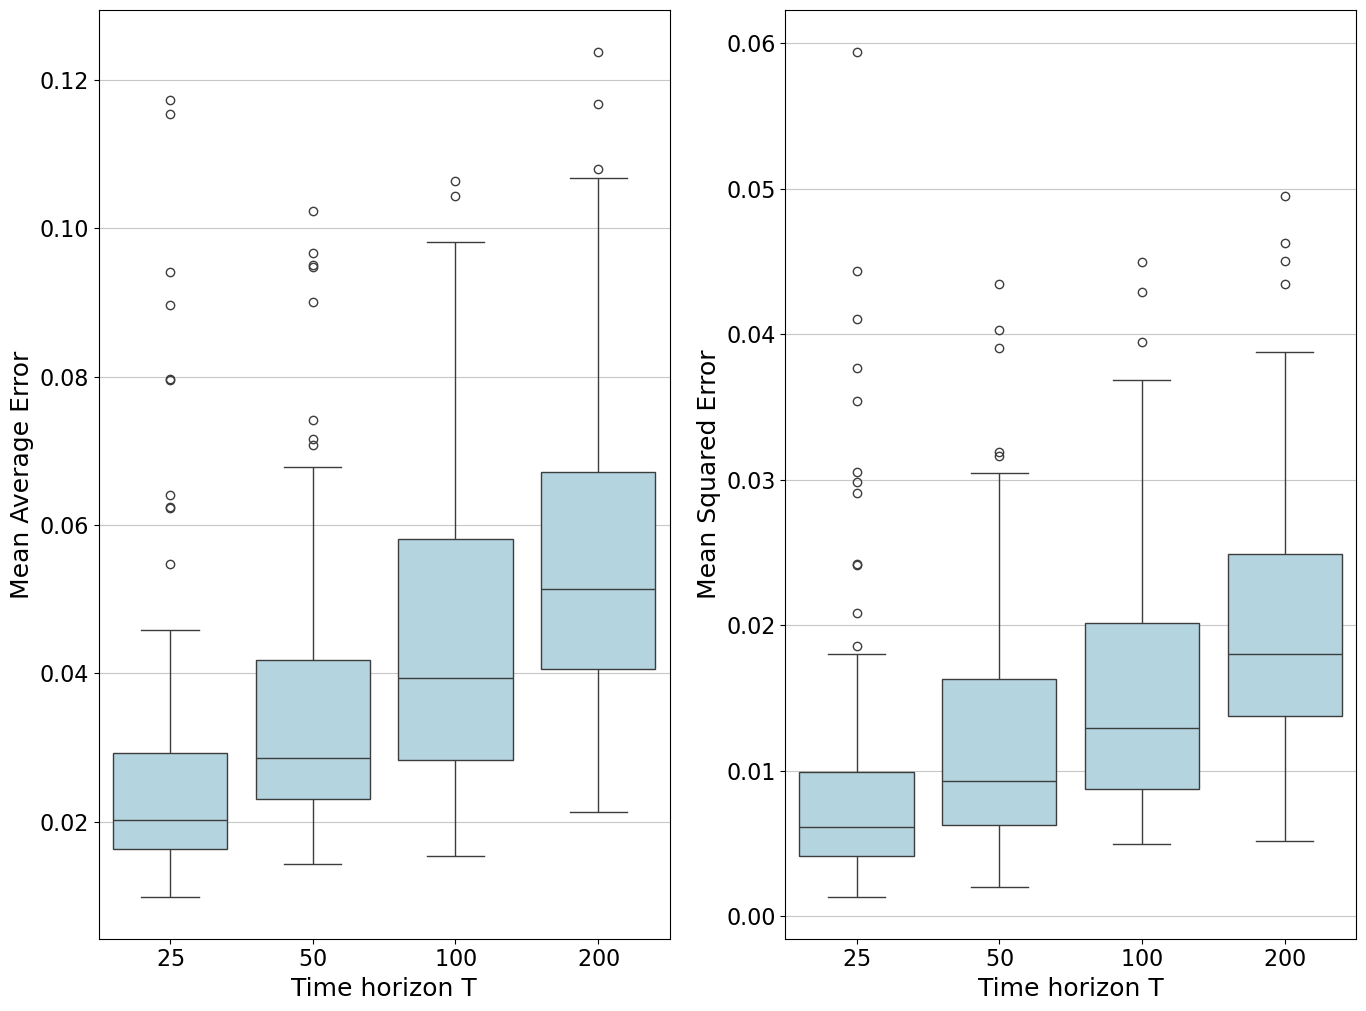

In [4]:
all_losses_x10_l1 = [arr * 1 for arr in all_losses_l1]
all_losses_x10_mse = [arr * 1 for arr in all_losses_mse]
# Number of predictions (for figure height scaling)
n_preds = 1

# Style settings
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [14, 5.5 * (n_preds + 0.9)],  # width fixed, height scales
})

# Example data (scaled by 10)
np.random.seed(0)


# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, sharey=False)  # sharey makes them comparable

# Left subplot
sns.boxplot(data=all_losses_x10_l1, color='lightblue', ax=axes[0])
axes[0].set_xticks(range(4))
axes[0].set_xticklabels([r"$25$", "$50$", "$100$", "$200$"])
axes[0].set_title("")
axes[0].set_ylabel("Mean Average Error")
axes[0].set_xlabel("Time horizon T")

# Right subplot
sns.boxplot(data=all_losses_x10_mse, color='lightblue', ax=axes[1])
axes[1].set_xticks(range(4))
axes[1].set_xticklabels([r"$25$", "$50$", "$100$", "$200$"])
axes[1].set_title("")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_xlabel("Time horizon T")

plt.tight_layout()
plt.show()